In [48]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('../dat/schools_w_clusters.csv')
raw = raw[['Cluster ID', 'Id', 'Site name', 'Address', 'Zip', 'Phone']]
raw['Zip'] = raw['Zip'].astype(str)
raw['Phone'] = raw['Phone'].astype(str)
raw.head()

,Cluster ID,Id,Site name,Address,Zip,Phone
0,0,0,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
1,0,1,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
2,0,215,salvation army temple,1 n. ogden,nan,2262649.0
3,0,509,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0
4,0,510,salvation army - temple / salvation army,1 n ogden ave,nan,2262649.0


In [3]:
print('name max len =', raw['Site name'].str.len().max())
print('address max len =', raw['Address'].str.len().max())
print('Zip max len =', raw['Zip'].str.len().max())
print('phone max len =', raw['Phone'].str.len().max())

name max len = 95
address max len = 43
Zip max len = 7
phone max len = 9


for a total of max length 154

## defs
The following insanity is how we need to convert into a useable Torch tensor of correct size and Variable...ness.

In [4]:
Variable(torch.from_numpy(np.random.rand(10)).float()).view(1,10)

Variable containing:
 0.0256  0.3088  0.0052  0.3363  0.2279  0.8210  0.0076  0.8412  0.8407  0.6581
[torch.FloatTensor of size 1x10]

In [5]:
def extend_to_length(string_to_expand, length):
    extension = '~' * (length-len(string_to_expand))
    return string_to_expand + extension

def record_formatter(record):
    name = extend_to_length(record['Site name'], 95)
    addr = extend_to_length(record['Address'], 43)
    zipp = extend_to_length(record['Zip'], 7)
    phon = extend_to_length(record['Phone'], 9)
    
    strings = list(''.join((name, addr, zipp, phon)))
    characters = np.array(list(map(ord, strings)))
    
    return Variable(torch.from_numpy(characters).float()).view(1,len(characters))

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.dense1 = nn.Sequential(
            nn.Linear(154,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,50))

        self.fc1 = nn.Sequential(
            nn.Linear(50,40),
            nn.ReLU(inplace=True),
            nn.Linear(40, 10),
            nn.Linear(10, 2))

    def forward_once(self, x):
        output = self.dense1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x0, x1, y):
        # euclidian distance
        diff = x0 - x1
        dist_sq = torch.sum(torch.pow(diff, 2), 1)
        dist = torch.sqrt(dist_sq)

        mdist = self.margin - dist
        dist = torch.clamp(mdist, min=0.0)
        loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
        loss = torch.sum(loss) / 2.0 / x0.size()[0]
        return loss

In [7]:
inpt1 = record_formatter(raw.iloc[0])
inpt2 = record_formatter(raw.iloc[1])

#print(inpt1)
#print(inpt2)

In [8]:
model = SiameseNetwork()

In [9]:
model.forward(inpt1, inpt2)

(Variable containing:
 -1.7514 -2.0703
 [torch.FloatTensor of size 1x2], Variable containing:
 -1.7514 -2.0703
 [torch.FloatTensor of size 1x2])

In [10]:
loss = ContrastiveLoss()

In [11]:
loss.forward(inpt1, inpt2, 1)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [25]:
inpt3 = record_formatter(raw.iloc[2])

loss.forward(inpt1, inpt3, 1)

Variable containing:
 31255
[torch.FloatTensor of size 1]

## data characteristics

In [14]:
raw.shape

(2693, 6)

In [15]:
raw['Cluster ID'].unique().shape

(740,)

## training

In [ ]:
model = SiameseNetwork()
loss  = ContrastiveLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [51]:
%%time

loss_holder = []

for epoch in range(200):
    for i in range(raw.shape[0]-1):
        # build data pairs
        inpt1 = record_formatter(raw.iloc[i])
        inpt2 = record_formatter(raw.iloc[i+1])
        label = 1 if (raw.iloc[i]['Cluster ID'] == raw.iloc[i+1]['Cluster ID']) else 0
        
        # forward
        otpt1, otpt2 = model.forward(inpt1, inpt2)
        optimizer.zero_grad()
        loss_calc = loss.forward(inpt1, inpt2, label)
        # reassign loss requiring gradient
        loss_calc = Variable(loss_calc.data, requires_grad=True)
        
        # backward
        loss_calc.backward()
        optimizer.step()
        
        # console.log
        loss_holder.append(loss_calc.data[0])
        if i == raw.shape[0]-2:
            print('loss for epoch', epoch, 'is', loss_calc.data[0])
            

loss for epoch 0 is 19633.0
loss for epoch 1 is 19633.0
loss for epoch 2 is 19633.0
loss for epoch 3 is 19633.0
loss for epoch 4 is 19633.0
loss for epoch 5 is 19633.0
loss for epoch 6 is 19633.0
loss for epoch 7 is 19633.0
loss for epoch 8 is 19633.0
loss for epoch 9 is 19633.0
loss for epoch 10 is 19633.0
loss for epoch 11 is 19633.0
loss for epoch 12 is 19633.0
loss for epoch 13 is 19633.0
loss for epoch 14 is 19633.0
loss for epoch 15 is 19633.0
loss for epoch 16 is 19633.0
loss for epoch 17 is 19633.0
loss for epoch 18 is 19633.0
loss for epoch 19 is 19633.0
loss for epoch 20 is 19633.0
loss for epoch 21 is 19633.0
loss for epoch 22 is 19633.0
loss for epoch 23 is 19633.0
loss for epoch 24 is 19633.0
loss for epoch 25 is 19633.0
loss for epoch 26 is 19633.0
loss for epoch 27 is 19633.0
loss for epoch 28 is 19633.0
loss for epoch 29 is 19633.0
loss for epoch 30 is 19633.0
loss for epoch 31 is 19633.0
loss for epoch 32 is 19633.0
loss for epoch 33 is 19633.0
loss for epoch 34 is 196

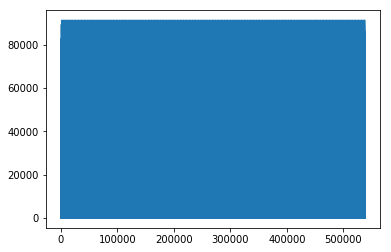

In [52]:
plt.plot(loss_holder)
plt.show()